# VarClump1D: Concept test
## _Variating $c$ and $\sigma$ together..._

In [1]:
%matplotlib inline

import sys
import numpy as np
import scipy as sp
import sympy as sym
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import interpolate, optimize

#import of acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import acontainer as ac

## Helper functions

In [2]:
"""
Helper function to visualize the quality of the solution
"""
def compare_plot(c, sig, xc, resolution=10, title=None):
    _xe = np.linspace(0., 1., 10*N, endpoint=True)
    _Dx = np.empty((10*N,N))
    for k in range(10*N):
        _Dx[k,:] = (_xe[k] - xc)

    phi_m = phi(_Dx, sig)
    u = np.dot(phi_m, c)
    plt.figure(figsize=(10,6))
    plt.plot(_xe, u, 'r-', label='Solution')
    plt.plot(x_, f(x_), 'b--', label='Data')
    plt.plot(xe, f(xe), 'go', label='Evaluation points')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.3, 1.0))
    plt.show()

## Variational Model

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}} L(x, u, u_x) \ dx  = \int_{\Omega \subset \mathbb{R}}(u(x)-f_0(x))^2 + \alpha \ \Psi_1(u(x)-f_0(x)) + \beta \ \Psi_2(|u_x(x)|) \ dx $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} =  2(u(x)-f_0(x)) + \alpha \ \Psi_1'(u(x)-f_0(x)) - \beta \ u_{xx}(x) \ \Psi_2''(|u_{x}(x)|) = 0$$

whit boundary condition $u(\partial \Omega) = 0$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x) = \sum_{i=1}^N c_i \ \phi(x; x_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2}{2 \sigma_i^2}}$$

## Loading data 1D from center pixel of cube

In [19]:
"""
Loading data
"""
cont = ac.AContainer()
#cont.load('../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits')
#cont.load('../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits')
cont.load('../../bindata/fits/cubes/M100line.image.fits')
#cont.load('../../bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits')

cube = cont.primary
spar = cube.standarize()
data = cube.data

INFO: Processing HDU 0 (Image) [acalib.io.formats]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.formats]


In [20]:
"""
Generating the data function
"""
f_data = data[:,300,300]
f_data /= np.max(f_data)
x = np.linspace(0., 1., len(f_data), endpoint=True)
f = sp.interpolate.interp1d(x, f_data, kind='linear')
x_ = np.linspace(0., 1., 10*len(f_data), endpoint=True)

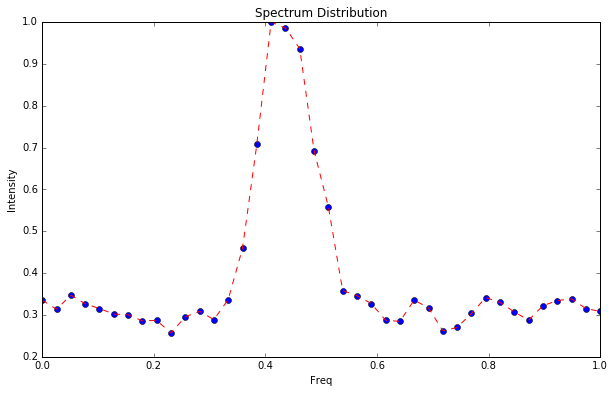

In [21]:
plt.figure(figsize=(10,6))
plt.plot(x, f_data, 'bo', x_, f(x_), 'r--')
plt.title('Spectrum Distribution')
plt.xlabel('Freq')
plt.ylabel('Intensity')
plt.show()

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$

In [23]:
z = sym.Symbol('z')

#Penalizing function and its derivatives
#psi1 = sym.exp(z)
#d1psi1 = sym.diff(psi1, z)
#d1psi1 = sym.lambdify(z, d1psi1, modules='numpy')
def d1psi1(x, scale=10.):
    x = scale*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('(4*(x-1)*x+2) / (4*(x-1)**2 * x**2 * (cosh(1/x + 1/(x-1))+1))')
    return ret
    

#Smoothing function and its derivatives
lamb = 0.5
#psi2 = 2*lamb*sym.log(1 + z**2/lamb)
psi2 = z**3
d1psi2 = sym.diff(psi2, z)
d2psi2 = sym.diff(d1psi2, z)
d1psi2 = sym.lambdify(z, d1psi2, modules='numpy')
d2psi2 = sym.lambdify(z, d2psi2, modules='numpy')

## $\phi$-RBF function to use and its derivatives

In [24]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, sig):
    retval = ne.evaluate('exp(-x**2/(2*(minsig**2+sig**2)))')
    #retval = np.exp(-x**2/(2*sig**2))
    return retval

def phix(x, sig):
    retval = ne.evaluate('-(1./(minsig**2+sig**2)) * exp(-x**2/(2*(minsig**2+sig**2))) * x')
    #retval = -(1./sig**2) * np.exp(-x**2/(2*sig**2)) * x
    return retval

def phixx(x, sig):
    retval = ne.evaluate('(1./(minsig**2+sig**2)**2) * exp(-x**2/(2*(minsig**2+sig**2))) * (x**2 - minsig**2 - sig**2)')
    #retval = (1./sig**4) * np.exp(-x**2/(2*sig**2)) * (x**2 - sig**2)
    return retval

## Euler-Lagrange Function class definition

In [25]:
class ELFunc():
    def __init__(self, f, xe, xc, c0, sig0, d1psi1, d2psi2, a=0., b=0.):
        #data function at evaluation and boundary points
        f0 = f(xe)
        fb = [f(0),f(1)]
        
        len_f0 = len(f0)
        len_xe = len(xe)
        len_xc = len(xc); N = len_xc;
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        """
        TODO:verify consistency
        """
        #if len_c0 != len_sig0: 
        #    print('Dimensions of c0 and sig0 must match!')
        #    return None
        #if (shape_Dx[0]+2 != shape_Dx[1]) or (shape_Dx[1] != len_c0):
        #    print('Dimensions of Dx are wrong!')
        #    return None
        """ 
        Computing distance matrix.
        Note: Evaluation and collocation points will be the same
        """
        Dx = np.empty((2*N-2,N))
        for i in range(2*N-2):
            Dx[i,:] = (xe[i] - xc)
        
        self.f0 = f0
        self.fb = fb
        self.xe = xe
        self.xc = xc
        self.Dx = Dx
        self.c = c0
        self.sig = sig0
        self.phi_m   = phi(Dx,sig0)
        self.phix_m  = phix(Dx,sig0)
        self.phixx_m = phixx(Dx,sig0)
        self.d1psi1 = d1psi1
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
    
    def set_c(self, c):
        self.c = c
    
    def set_sig(self, sig):
        self.sig = sig
        self.phi_m   = phi(self.Dx,sig)
        self.phix_m  = phix(self.Dx,sig)
        self.phixx_m = phixx(self.Dx,sig)
    
    """
    Function to optimize c and sig together
    """
    def F(self, X):
        #unpacking parameters
        N = len(X)/2
        c = X[0:N]
        sig = X[N:]

        #phi function's evaluation
        phi_m   = phi(self.Dx, sig)
        phix_m  = phix(self.Dx, sig)
        phixx_m = phixx(self.Dx, sig)
        

        #computing the Euler-Lagrange equation
        u   = np.dot(phi_m, c)
        ux  = np.dot(phix_m, c)
        uxx = np.dot(phixx_m, c)
        el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0) - self.b*uxx*self.d2psi2(np.abs(ux))
        
        #evaluating at boundary
        bc = [np.dot(phi(-self.xc,sig),c)-self.fb[0], np.dot(phi(1.-self.xc,sig),c)-self.fb[-1]]
        #bc = [np.dot(phi(-self.xc,sig),c), np.dot(phi(1.-self.xc,sig),c)]
        #bc = [np.dot(phix(-self.xc,sig),c), np.dot(phix(1.-self.xc,sig),c)]
        #print(u); print(ux); print(uxx)
        return np.concatenate([el,bc])

## Center and evaluation points

In [26]:
#number of gaussians
N = 10

""" Computing center points """
xc = np.linspace(0., 1., N+2, endpoint=True)[1:-1]
print('Center points:')
print(xc)
print('---------------------------------------------')

""" 
Computing evaluation points, i.e, points where
EL equation will be evaluated
"""
xe = np.linspace(0., 1., 2*N, endpoint=True)[1:-1]
print('Evaluation points:')
print(xe)
print('---------------------------------------------')

Center points:
[ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
---------------------------------------------
Evaluation points:
[ 0.05263158  0.10526316  0.15789474  0.21052632  0.26315789  0.31578947
  0.36842105  0.42105263  0.47368421  0.52631579  0.57894737  0.63157895
  0.68421053  0.73684211  0.78947368  0.84210526  0.89473684  0.94736842]
---------------------------------------------


## Initial conditions

In [27]:
"""
Defining initial parameter values
"""
c0 = f(xc)/N
sig0 = (1./(N))*np.ones(N)

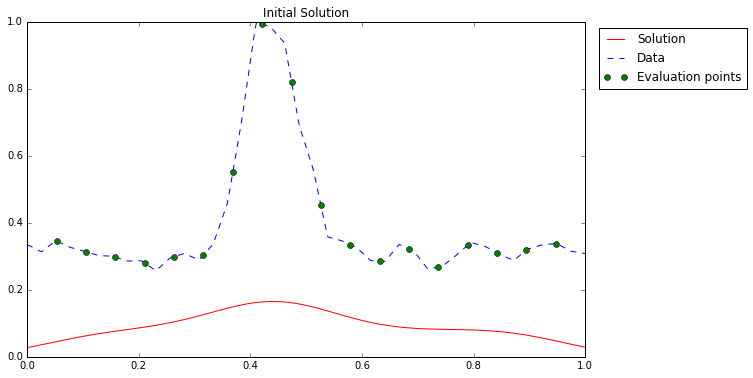

In [28]:
"""
Visualizing the 'initial' solution
"""
compare_plot(c0, sig0, xc, title='Initial Solution')

## Solving it!

In [29]:
#Instantiating the EL func object
elf1 = ELFunc(f, xe, xc, c0, sig0, d1psi1, d2psi2, a=0., b=0.)
elf2 = ELFunc(f, xe, xc, c0, sig0, d1psi1, d2psi2, a=0.1, b=0.)

In [30]:
#solve it!
#sol = sp.optimize.fsolve(elf1.F, np.concatenate([elf1.c, elf1.sig]))
sol = sp.optimize.root(elf1.F, np.concatenate([elf1.c, elf1.sig]), method='lm')
op_c = sol.x[0:N]
op_sig = sol.x[N:]
print(op_c)
print(op_sig)

[ 0.13858393  0.19460381  0.17332243  0.21255803  0.69062525 -0.03215561
  0.04483712 -0.37935298  0.240761    0.09653474]
[ 0.11163241  1.97841056  1.88174163 -0.05976352  0.04973604  0.88252669
  1.53988902  0.59108416  0.31743973  0.39342645]


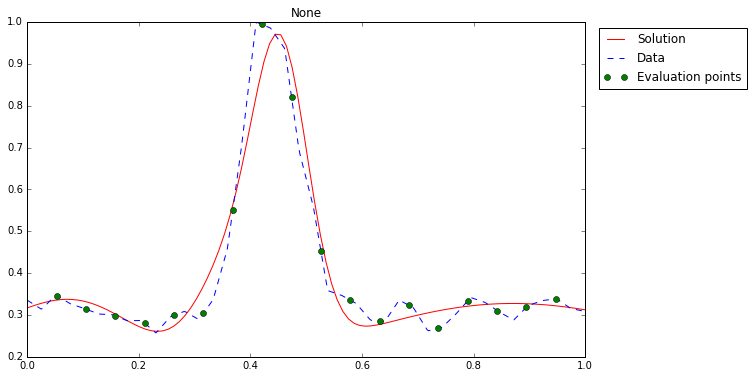

In [31]:
compare_plot(op_c, op_sig, xc)

In [32]:
sol = sp.optimize.root(elf2.F, np.concatenate([elf2.c, elf2.sig]), method='lm')
op_c = sol.x[0:N]
op_sig = sol.x[N:]
print(op_c)
print(op_sig)

[ 0.07589957 -0.0086032   0.02787616  0.17158807  0.51105667  0.07178702
  0.06014373  0.04315224  0.02297713  0.11852395]
[ 0.25792288  0.32002632  1.09602567  0.14503335  0.05555818  1.49567698
  1.78191864  1.61968242  0.02240565  0.17987298]


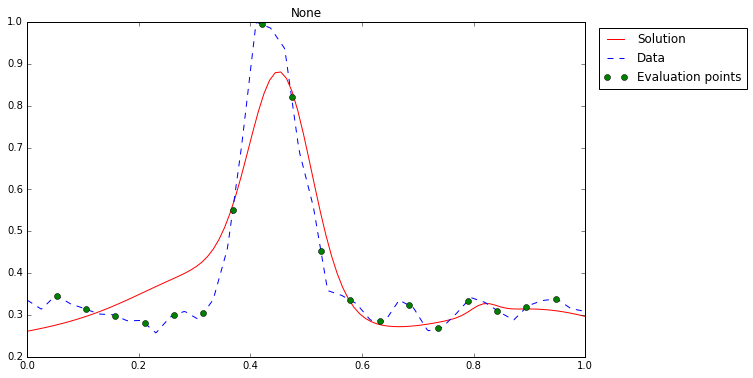

In [33]:
compare_plot(op_c, op_sig, xc)

TODO (last season):
- try different bc
- study 2 gaussians case
- try solver: min |F|
- study well posedeness of the problem

- ver diferencias entre f y el
- separa dos versiones
- $\sigma_i^2 = \sigma_0^2 + \widehat{\sigma}_i^2$

IDEAS:
* Other methods for solving the ODE/PDE: FEM, Spectral Methods, ...
* Change evaluation points at each iteration
* Define good function $\Psi_1$ and $\Psi_2$